<a href="https://colab.research.google.com/github/LuchoValr/The-effect/blob/main/Cap17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Haciendo un primer estudio de eventos


In [2]:
!pip install causaldata
import pandas as pd 
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from causaldata import google_stock

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for causaldata: filename=causaldata-0.1.3-py3-none-any.whl size=2645603 sha256=28d9768d720237e845f4b1707506aa007098be00630b2f13bc07663a8f16015d
  Stored in directory: /root/.cache/pip/wheels/4a/8f/9f/13d3a7ab29b8a8c68f3e5dcc0fe00d0e8eef62fc508a20c7c6
Successfully built causaldata


In [11]:
goog = google_stock.load_pandas (). data

In [12]:
# Create estimation data set
goog['Date'] = pd.to_datetime(goog['Date'])
est_data = goog.loc[(goog['Date'] >= pd.Timestamp (2015 ,5 ,1)) & (goog['Date'] < pd.Timestamp (2015 ,7 ,31))]


In [13]:
# And observation data
obs_data = goog.loc[(goog['Date'] >= pd.Timestamp (2015 ,8 ,6)) & (goog['Date'] < pd.Timestamp (2015 ,8 ,24))]

In [14]:
# Estimate a model predicting stock price with market return
m = smf.ols('Google_Return ~ SP500_Return ', data = est_data ).fit()

In [15]:
# Get AR
# Using mean of estimation return
goog_return = np.mean(est_data['Google_Return'])
obs_data['AR_mean'] = obs_data['Google_Return'] - goog_return
# Then comparing to market return
obs_data['AR_market'] = obs_data['Google_Return'] - obs_data['SP500_Return']
# Then using model fit with estimation data
obs_data['risk_pred'] = m.predict(obs_data)
obs_data['AR_risk'] = obs_data['Google_Return'] - obs_data['risk_pred']

<ipython-input-15-18411c9633cb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_data['AR_mean'] = obs_data['Google_Return'] - goog_return
<ipython-input-15-18411c9633cb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_data['AR_market'] = obs_data['Google_Return'] - obs_data['SP500_Return']
<ipython-input-15-18411c9633cb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

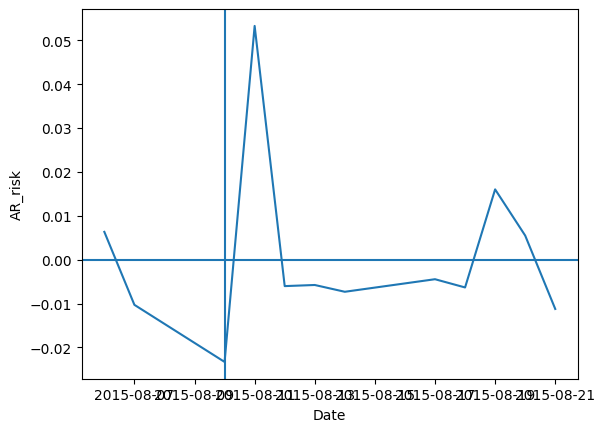

In [16]:
# Graph the results
sns.lineplot(x = obs_data['Date'],y = obs_data['AR_risk'])
plt.axvline(pd.Timestamp (2015 ,8 ,10))
plt.axhline (0)

#Estudio de eventos con diferentes grupos

In [17]:
np.random.seed (10)

In [ ]:
# Ten groups with ten periods each
id = pd.DataFrame ({'id': range(0,10), 'key': 1})
t = pd.DataFrame ({'t': range(1,11), 'key': 1})
d = id.merge(t, on = 'key')
# Add an event in period 6 with a one-period effect
d['Y'] = np.random.normal (0,1,100) + 1*(d['t'] == 6)

In [19]:
# Estimate our ]model using time 5 as reference
m = smf.ols('Y~C(t, Treatment(reference = 5))', data = d)

In [20]:
# Fit with SEs clustered at the group level
m = m.fit(cov_type = 'cluster',cov_kwds ={'groups': d['id']})

In [21]:
# Get coefficients and CIs
# The original table will have an intercept up top
# But we'll overwrite it with our 5 reference
p = pd.DataFrame ({'t': [5,1,2,3,4,6,7,8,9,10],
                   'b': m.params , 'se': m.bse})


In [22]:
# And add our period -5 zero
p.iloc [0] = [5, 0, 0]

In [23]:
# Sort for plotting
p = p.sort_values('t')

In [24]:
# and make CIs by scaling the standard error
p['ci'] = 1.96*p['se']

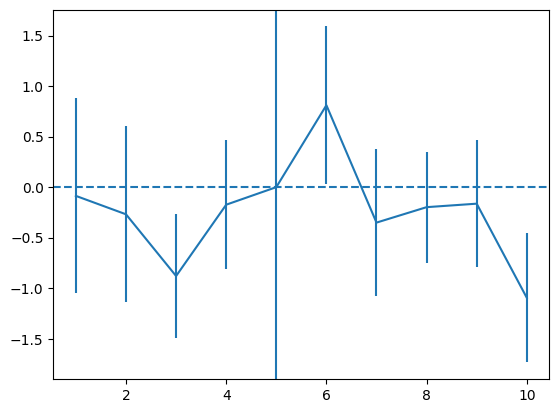

In [25]:
# Plot the estimates as connected lines with error bars
plt.errorbar(x = 't', y = 'b', yerr = 'ci', data = p)
# Add a horizontal line at 0
plt.axhline(0, linestyle = 'dashed')
# And a vertical line at the treatment time
plt.axvline (5)